In [109]:
# do not touch this cell 
%load_ext jupyter_record


The jupyter_record extension is already loaded. To reload it, use:
  %reload_ext jupyter_record


In [101]:
%%git_commit

import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack,vstack
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, plot_roc_curve


In [3]:
%%git_commit

training = pd.read_csv('../archive/Combined_Flights_2018.csv').sample(100000)
testing = pd.read_csv('../archive/Combined_Flights_2019.csv').sample(100000)




In [5]:
%%git_commit

training = training[training['Diverted'] == 0]
testing = testing[testing['Cancelled'] == 0]



In [7]:
%%git_commit
print(training.keys())

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [8]:
%%git_commit
training = training[['DayOfWeek', 'Airline', 'CRSDepTime', 'Origin', 'Dest', 'Distance', 'ArrDel15']]
testing = testing[['DayOfWeek', 'Airline', 'CRSDepTime', 'Origin', 'Dest', 'Distance', 'ArrDel15']]



In [9]:
%%git_commit

training.dropna()
training = training.reset_index(drop=True)
testing.dropna()
testing = testing.reset_index(drop=True)


In [11]:
%%git_commit
training = training.rename(columns = {'DayOfWeek' : 'Weekend'})
training['Weekend'] = (training['Weekend'] > 5).astype(int)
testing = testing.rename(columns = {'DayOfWeek' : 'Weekend'})
testing['Weekend'] = (testing['Weekend'] > 5).astype(int)

In [13]:
%%git_commit
training['Airline'].nunique()

28

In [14]:
%%git_commit
carrier_df = training[['Airline','ArrDel15']].groupby('Airline').sum().sort_values(by='ArrDel15',ascending=False)
carrier_df['CARRIER_cat'] = pd.qcut(carrier_df['ArrDel15'], 28, labels = False)
carrier_df


,ArrDel15,CARRIER_cat
Airline,,
Southwest Airlines Co.,4637.0,27
United Air Lines Inc.,2083.0,26
SkyWest Airlines Inc.,1716.0,25
JetBlue Airways,1398.0,24
American Airlines Inc.,1364.0,23
Delta Air Lines Inc.,996.0,22
Republic Airlines,656.0,21
ExpressJet Airlines Inc.,600.0,20
Frontier Airlines Inc.,572.0,19


In [15]:
%%git_commit
data_carrier = carrier_df.loc[training['Airline']].reset_index()
training['CARRIER_cat'] = data_carrier['CARRIER_cat']


In [16]:
%%git_commit
data_carrier = carrier_df.loc[testing['Airline']].reset_index()
testing['CARRIER_cat'] = data_carrier['CARRIER_cat']

In [17]:
%%git_commit
training['CRSDepTime'] = training['CRSDepTime']//100
testing['CRSDepTime'] = testing['CRSDepTime']//100

In [19]:
%%git_commit
training['CRSDepTime'].nunique()


24

In [21]:
%%git_commit
time_blk_df = training[['CRSDepTime','ArrDel15']].groupby('CRSDepTime').sum().sort_values(by='ArrDel15',ascending=False)
time_blk_df['TIME_cat'] = pd.qcut(time_blk_df['ArrDel15'], 19, labels = False)
time_blk_df

,ArrDel15,TIME_cat
CRSDepTime,,
17,1694.0,18
18,1510.0,18
19,1438.0,17
16,1328.0,16
15,1313.0,15
14,1281.0,14
20,1209.0,14
12,1141.0,13
13,1136.0,12


In [22]:
%%git_commit
data_time = time_blk_df.loc[training['CRSDepTime']].reset_index()
training['DEP_TIME_cat'] = data_time['TIME_cat']

In [23]:
%%git_commit
data_time = time_blk_df.loc[testing['CRSDepTime']].reset_index()
testing['DEP_TIME_cat'] = data_time['TIME_cat']

In [29]:
%%git_commit

training['Origin'].nunique()


366

In [45]:
%%git_commit
origin_df = training[['Origin','ArrDel15']].groupby('Origin').sum().sort_values(by='ArrDel15',ascending=False)
origin_df['ORIGIN_cat'] = pd.qcut(origin_df['ArrDel15'], 10, labels = False)
origin_df

,ArrDel15,ORIGIN_cat
Origin,,
ORD,1177.0,9
DEN,820.0,9
EWR,689.0,9
ATL,639.0,9
SFO,588.0,9
...,...,...
DRT,0.0,0
HVN,0.0,0
IMT,0.0,0


In [46]:
%%git_commit
cat = 10
for key in testing['Origin'].unique():
    if key not in origin_df.index:
        origin_df.loc[key] = [0, cat]
origin_df

,ArrDel15,ORIGIN_cat
Origin,,
ORD,1177.0,9
DEN,820.0,9
EWR,689.0,9
ATL,639.0,9
SFO,588.0,9
...,...,...
ATY,0.0,10
APN,0.0,10
BFM,0.0,10


In [47]:
%%git_commit
data_origin = origin_df.loc[training['Origin']].reset_index()
training['ORIGIN_cat'] = data_origin['ORIGIN_cat']

data_origin = origin_df.loc[testing['Origin']].reset_index()
testing['ORIGIN_cat'] = data_origin['ORIGIN_cat']

In [48]:
%%git_commit
training['Dest'].nunique()



366

In [51]:
%%git_commit

dest_df = training[['Dest','ArrDel15']].groupby('Dest').sum().sort_values(by='ArrDel15',ascending=False)
dest_df['DEST_cat'] = pd.qcut(dest_df['ArrDel15'], 9, labels = False)
dest_df


,ArrDel15,DEST_cat
Dest,,
ORD,1071.0,8
EWR,820.0,8
DEN,778.0,8
SFO,716.0,8
ATL,647.0,8
...,...,...
BRW,0.0,0
BRD,0.0,0
BQK,0.0,0


In [52]:
%%git_commit
cat = 9
for key in testing['Dest'].unique():
    if key not in dest_df.index:
        dest_df.loc[key] = [0, cat]
dest_df

,ArrDel15,DEST_cat
Dest,,
ORD,1071.0,8
EWR,820.0,8
DEN,778.0,8
SFO,716.0,8
ATL,647.0,8
...,...,...
XWA,0.0,9
GST,0.0,9
DLG,0.0,9


In [54]:
%%git_commit
data_dest = dest_df.loc[training['Dest']].reset_index()
training['DEST_cat'] = data_dest['DEST_cat']

data_dest = dest_df.loc[testing['Dest']].reset_index()
testing['DEST_cat'] = data_dest['DEST_cat']

In [69]:
%%git_commit
training = training[['Weekend', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'Distance', 'ArrDel15']]

testing = testing[['Weekend', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'Distance', 'ArrDel15']]

training

,Weekend,CARRIER_cat,DEP_TIME_cat,ORIGIN_cat,DEST_cat,Distance,ArrDel15
0,1,27,4,9,8,1057.0,0.0
1,0,26,12,8,8,177.0,0.0
2,0,23,10,9,8,1440.0,0.0
3,0,26,18,9,8,1208.0,0.0
4,0,16,9,9,8,1107.0,0.0
...,...,...,...,...,...,...,...
99754,1,25,9,9,5,156.0,0.0
99755,1,11,18,9,7,763.0,0.0
99756,0,27,9,9,8,867.0,1.0
99757,1,23,14,9,7,1021.0,0.0


In [70]:
%%git_commit
training_X = training.drop('ArrDel15', axis=1)
training_y =  training[['ArrDel15']]

In [71]:
%%git_commit
testing_X = testing.drop('ArrDel15', axis=1)
testing_y =  testing[['ArrDel15']]

In [72]:
%%git_commit
training_X = training_X.values
training_y = training_y.values

In [73]:
%%git_commit
testing_X = testing_X.values
testing_y = testing_y.values

In [79]:
%%git_commit
model = StandardScaler()
training_X = model.fit_transform(training_X)
testing_X = model.transform(testing_X)

model = MinMaxScaler()
training_X = model.fit_transform(training_X)
testing_X = model.transform(testing_X)

In [88]:
%%git_commit
index_t = np.argwhere(np.isnan(testing_y))
index = np.argwhere(np.isnan(training_y))

In [94]:
%%git_commit
training_X = np.delete(training_X, index, axis = 0)

In [96]:
%%git_commit
testing_X = np.delete(testing_X, index_t, axis = 0)

In [95]:
%%git_commit
training_y = np.delete(training_y, index, axis = 0)

In [97]:
%%git_commit
testing_y = np.delete(testing_y, index_t, axis = 0)

In [98]:
%%git_commit
model = tree.DecisionTreeClassifier()
model = model.fit(training_X, training_y)

In [99]:
%%git_commit
y_pred_test = model.predict(testing_X)

In [102]:
%%git_commit
print(confusion_matrix(testing_y, y_pred_test))


[[70080  9068]
 [15982  2759]]


In [104]:
%%git_commit
print(classification_report(testing_y, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85     79148
         1.0       0.23      0.15      0.18     18741

    accuracy                           0.74     97889
   macro avg       0.52      0.52      0.51     97889
weighted avg       0.70      0.74      0.72     97889



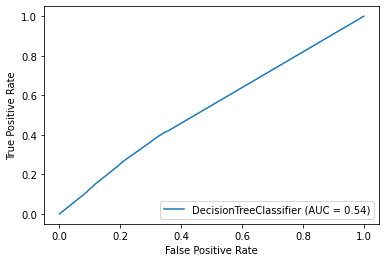

In [106]:
%%git_commit
plot_roc_curve(model, testing_X, testing_y)


In [ ]:
%%git_commit
